In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
os.chdir("/home/naxos2-raid25/kneel027/home/kneel027/MindEye_Imagery/src/")
import torch
from diffusers import StableDiffusionXLPipeline, LCMScheduler, AutoencoderKL
from PIL import Image

from models import IPAdapterPlusXL_LoRA, IPAdapterPlusXLEmbedder

In [16]:
base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
# base_model_path = "SG161222/RealVisXL_V1.0"
image_encoder_path = "IP-Adapter/models/image_encoder"
ip_ckpt = "IP-Adapter/sdxl_models/ip-adapter-plus_sdxl_vit-h.safetensors"
device = "cuda"

In [17]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [18]:
# load SDXL pipeline
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    add_watermarker=False,
    variant="fp16",
    vae=vae,
).to(device)
# pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
# pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl", torch_dtype=torch.float16)
# pipe.fuse_lora()
# pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
# load ip-adapter
ip_model = IPAdapterPlusXL_LoRA(pipe, image_encoder_path, ip_ckpt, device, num_tokens=16)
ipembedder = IPAdapterPlusXLEmbedder(image_encoder_path, ip_ckpt, device, num_tokens=16)

self.image_encoder.config.hidden_size 1280


The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Loading LORA weights


In [ ]:
# read image prompt
# image = Image.open("woman.png")
image = Image.open("/home/naxos2-raid25/kneel027/home/kneel027/data/umn-imagery/nsddata_stimuli/stimuli/imagery_images/1.png")
image.resize((512, 512))
image_embed = ipembedder.get_image_embeds(image)
print(image_embed.shape)

torch.Size([1, 16, 2048])


In [ ]:
# generate image variations with only image prompt
num_samples = 2
# images = ip_model.generate(pil_image=image, image_embeds=None, num_samples=num_samples, num_inference_steps=4, seed=42)
images = ip_model.generate(pil_image=None, image_embeds=image_embed, num_samples=num_samples, num_inference_steps=4)#, seed=42)
grid = image_grid(images, 1, num_samples)
grid

ValueError: not enough values to unpack (expected 3, got 2)

torch.Size([1, 257, 1280])


  0%|          | 0/4 [00:00<?, ?it/s]

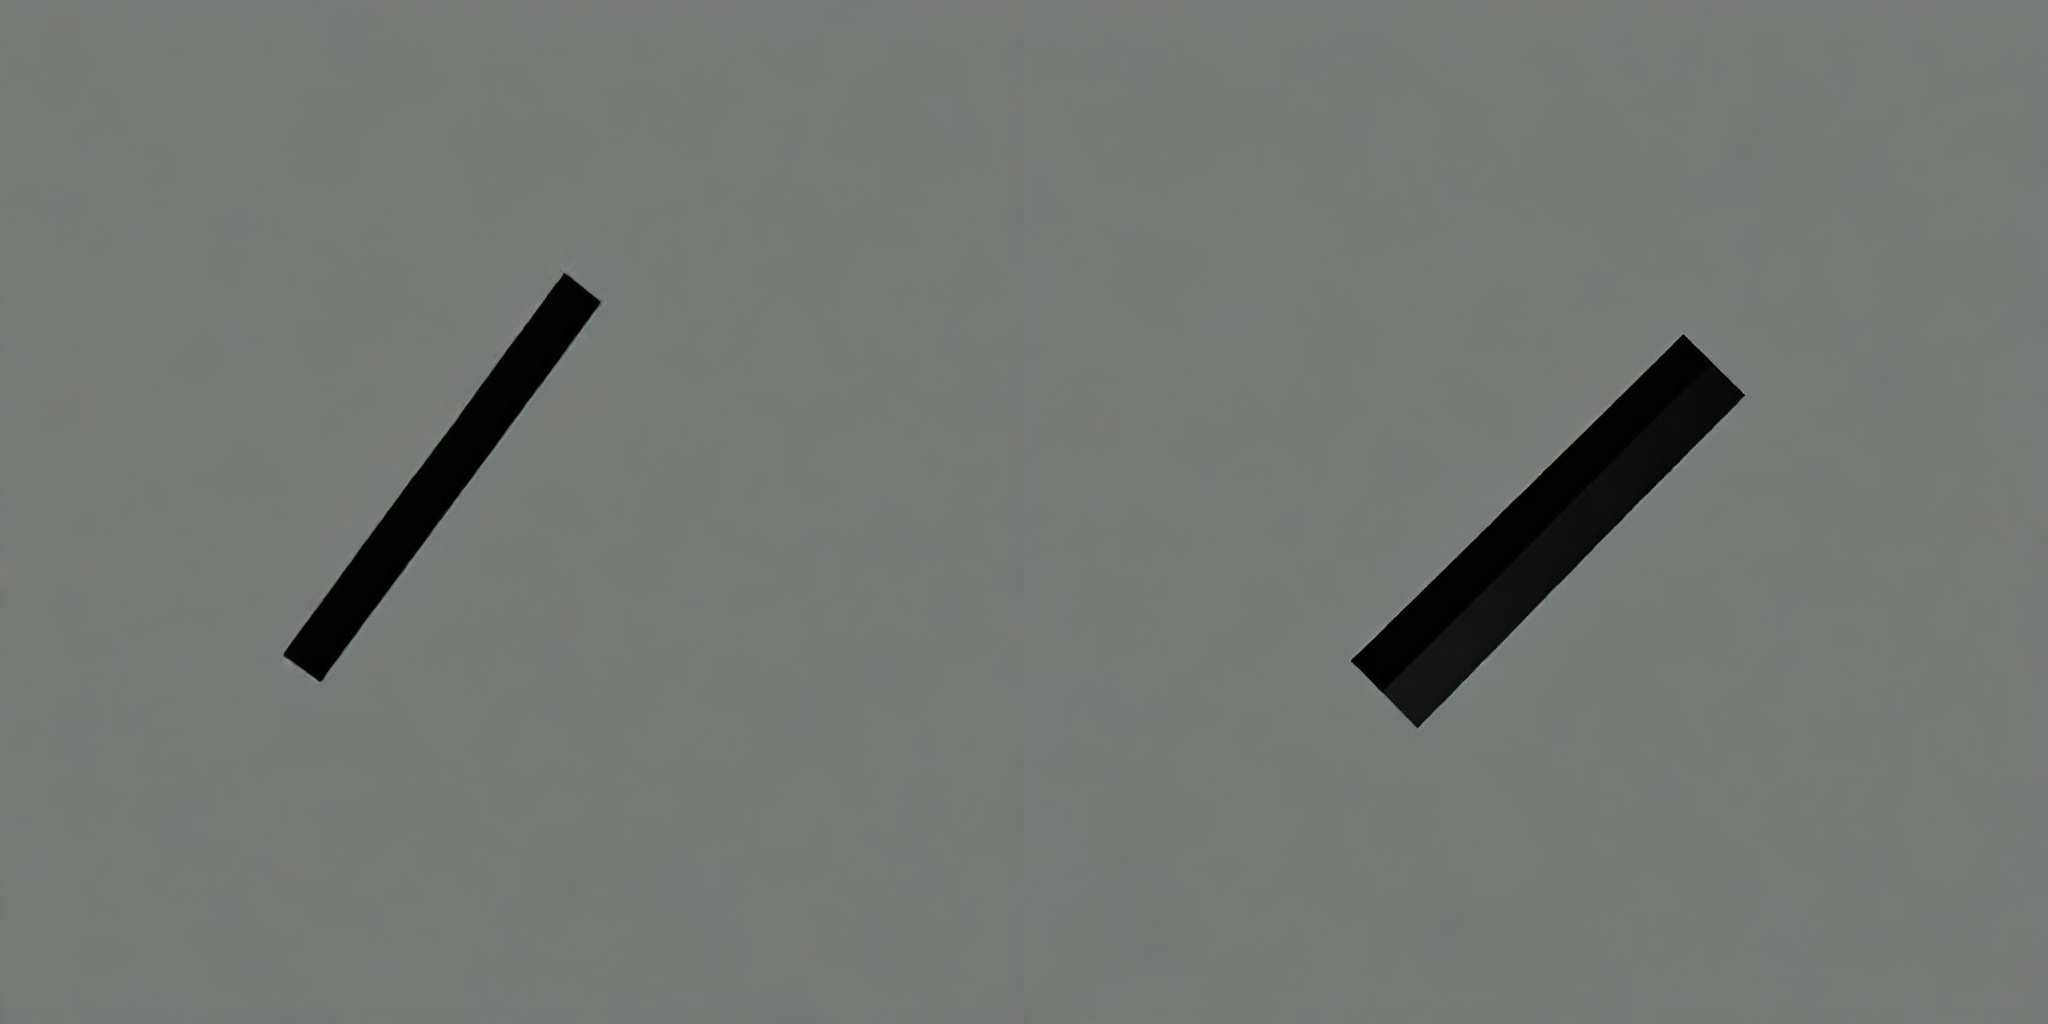

In [ ]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=num_samples, num_inference_steps=4, seed=42,
        prompt="best quality, high quality", scale=1)
grid = image_grid(images, 1, num_samples)
grid